In [1]:
from skimage.io import imread
from skimage.transform import resize
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
with zipfile.ZipFile('dicom_data.zip', 'r') as zip_ref:
    zip_ref.extractall('dicom_data/')

In [3]:
def takeLabel(string):
  if string == "clean":
    return 0
  else:
    return 1

In [4]:
images = []
target = []
base_dir = "dicom_data/dicom_data"
listdir = os.listdir(base_dir)
for sub_dir in listdir:
  # print(sub_dir)
  label = takeLabel(sub_dir)
  sub_dir = os.path.join(base_dir,sub_dir)
  list_sub_dir = os.listdir(sub_dir)
  for file in list_sub_dir:
    # print(file)
    file_path = os.path.join(sub_dir,file)
    try:
      img = imread(file_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      dimension=(150, 150)
      img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
      images.append(img_resized)
      target.append(label)
    except:
      print(file_path)

In [5]:
target = np.array(target)
images = np.array(images)

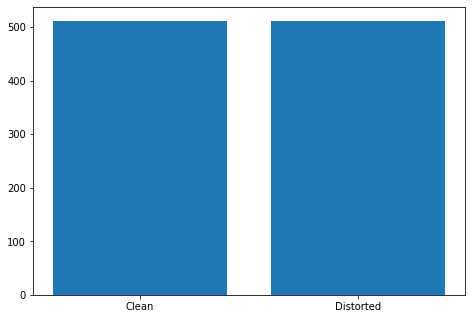

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Clean', 'Distorted']
counts = [np.count_nonzero(target==0),np.count_nonzero(target==1)]
ax.bar(langs,counts)
plt.show()

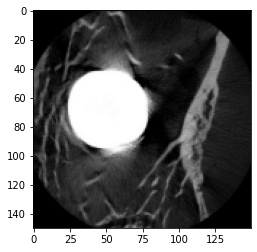

In [7]:
plt.imshow(images[765])

In [8]:
X_train, X_test_val, y_train, y_test_val = train_test_split(
    images, target, test_size=0.4,random_state=109)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.4,random_state=109)

In [ ]:
y_val

In [10]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))
conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [11]:
NUM_CLASSES = 2
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['acc']
)

In [13]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience= 5)
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', 
                            verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit(
        X_train,y_train,
        callbacks = [early_stop,checkpoint],
        validation_data=(X_val,y_val),
        epochs=5
)

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 0.2683 - acc: 0.8958
Epoch 00001: val_acc improved from -inf to 1.00000, saving model to model.h5
20/20 [==============================] - 182s 9s/step - loss: 0.2683 - acc: 0.8958 - val_loss: 0.0376 - val_acc: 1.0000
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.0324 - acc: 0.9951
Epoch 00002: val_acc did not improve from 1.00000
20/20 [==============================] - 192s 10s/step - loss: 0.0324 - acc: 0.9951 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.0154 - acc: 0.9984
Epoch 00003: val_acc did not improve from 1.00000
20/20 [==============================] - 183s 9s/step - loss: 0.0154 - acc: 0.9984 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.0130 - acc: 0.9984
Epoch 00004: val_acc did not improve from 1.00000
20/20 [==============================] - 168s 9s/step - loss

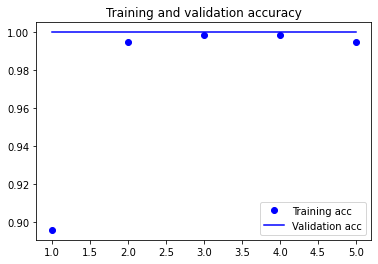

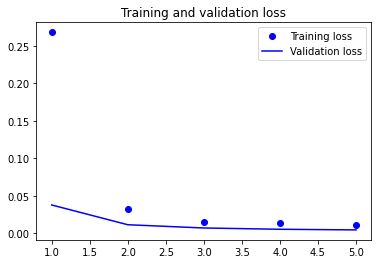

In [15]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [16]:
from tensorflow.keras.models import load_model
model = load_model("model.h5")

In [19]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 35s 5s/step - loss: 0.0413 - acc: 1.0000


[0.041255753487348557, 1.0]

In [22]:
X_test[2].shape

(150, 150, 3)

In [26]:
model.predict(X_test)

array([[0.02077472],
       [0.9962762 ],
       [0.02638653],
       [0.996753  ],
       [0.9911366 ],
       [0.03040719],
       [0.04497883],
       [0.9226198 ],
       [0.04946461],
       [0.9839736 ],
       [0.99731255],
       [0.9969306 ],
       [0.05406424],
       [0.02903607],
       [0.94354403],
       [0.9592861 ],
       [0.02371061],
       [0.01278061],
       [0.9926137 ],
       [0.9360547 ],
       [0.02245331],
       [0.99264586],
       [0.92745495],
       [0.0246667 ],
       [0.04542586],
       [0.07147709],
       [0.95154893],
       [0.94227654],
       [0.04389712],
       [0.9837346 ],
       [0.9916141 ],
       [0.01089385],
       [0.02462441],
       [0.03510877],
       [0.9953654 ],
       [0.05608293],
       [0.03976378],
       [0.9921016 ],
       [0.9920968 ],
       [0.99586743],
       [0.9481519 ],
       [0.98588485],
       [0.03734246],
       [0.08526656],
       [0.9872391 ],
       [0.9828278 ],
       [0.03437147],
       [0.992

In [27]:
y_test

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0])